

# group

groupによるlabel付けを行う。

https://aiida-tutorials.readthedocs.io/en/latest/pages/2020_Intro_Week/sections/data.html#how-to-group-nodes
では、tutorialをまとめたり、pseudopotentialをまとめるのに用いている。

groupのAiiDAの説明は
https://aiida.readthedocs.io/projects/aiida-core/en/latest/howto/data.html?highlight=Group
にある。

## 用途

例えば、WorkChainをgroup登録するには、
1. WorkChainをつくる。
2. WorkChainをgroup登録する。

という順序になる。


In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

In [2]:
from aiida.engine import calcfunction,workfunction, WorkChain, ToContext, submit,run,while_
from aiida.orm import Str,Float, Dict, load_node
import numpy as np
from aiida.plugins import DataFactory, WorkflowFactory
import time
from aiida.orm import Group

In [3]:
# 二度目以降は以下を行う。
if True:
    from aiida.orm import Group
    for name in ["rescaledvolume/Si/scale1","rescaledvolume/Ge/scale1",
                 "rescaledvolume/Si/scale2","rescaledvolume/Ge/scale2",
                "rescaledvolume/scale1","rescaledvolume/scale2"
                ]:
        try:
            group = Group.objects.get(label=name)
            print(group)
        except:
            continue
        Group.objects.delete(group.pk)
        print("delete group", name, group.pk)

In [4]:
# define inputs
def define_inputs(elementstr, factor_list =  [0.98, 0.99, 1.0, 1.1, 1.2]):
    element = Str(elementstr)
    element.store()
    print("element.pk",element.pk)

    ArrayData = DataFactory('array')
    factor_array = ArrayData()
    factor_array.set_array("vector",np.array(factor_list))
    return element, factor_array
    
# run
element, factor_array = define_inputs("Si")
import os
absolute_path = Str(os.getcwd())

element.pk 691


In [5]:
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")
builder = rescaledstructuresvolume.get_builder()
builder.element=element
builder.factor_array=factor_array
builder.absolute_path = absolute_path
future = submit(builder)

In [6]:
while not future.is_finished:
    print(future.exit_message)
    if future.exception is not None:
        print(future.exception)
        raise
    time.sleep(2)
print(future.is_finished_ok)

print(future.outputs.volume_avg.value)

None
None
None
True
47.821088881098


In [7]:
pk = future.outputs.volume_avg.pk
pk

715

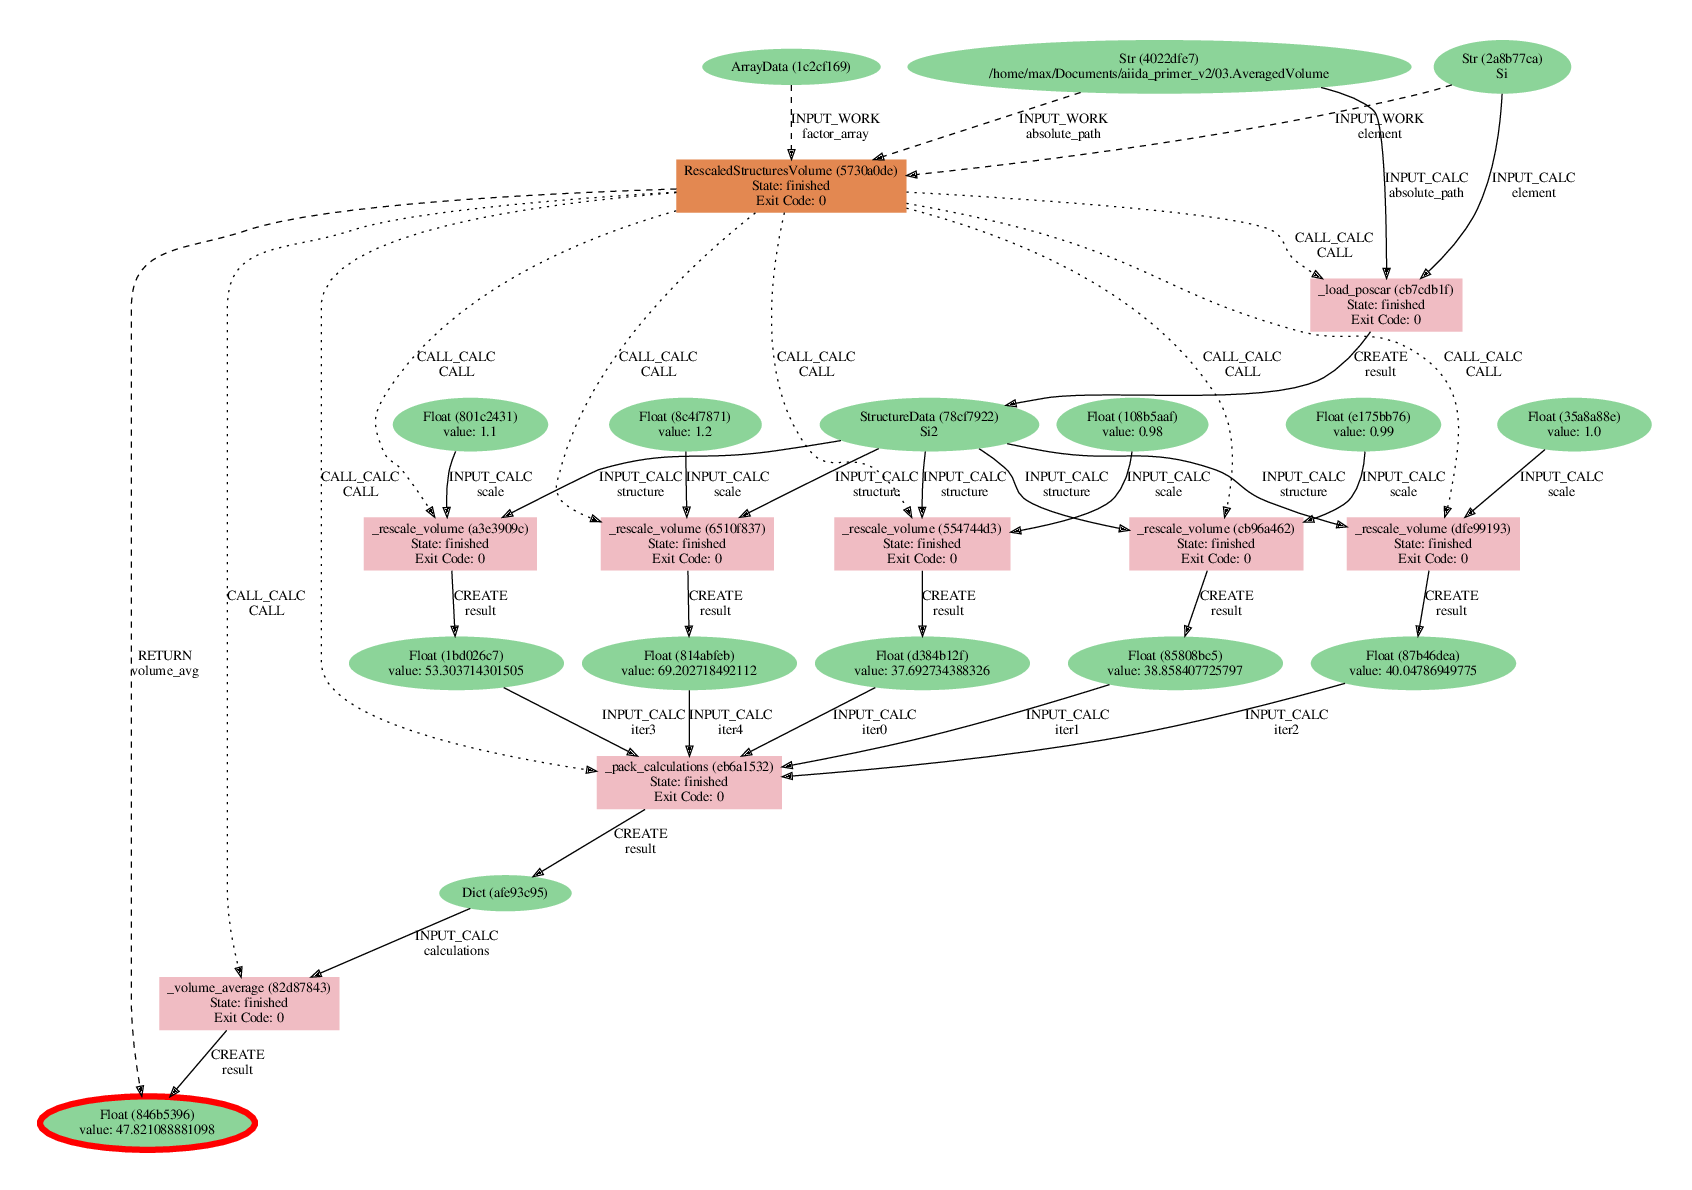

In [8]:
import subprocess
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

In [9]:
group = Group(label="rescaledvolume/Si/scale1")
group.store()
group.add_nodes(future)

In [10]:
group.add_nodes(future)

## change elements

In [11]:
element, factor_array = define_inputs("Ge")
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")
builder = rescaledstructuresvolume.get_builder()
builder.element=element
builder.factor_array=factor_array
builder.absolute_path = absolute_path
future = submit(builder)

element.pk 716


In [12]:
group = Group(label="rescaledvolume/Ge/scale1")
group.store()
group.add_nodes(future)

## change element and factor list

In [13]:
element, factor_array = define_inputs("Si",factor_list =  [0.98, 0.99, 1.0, 1.01, 1.02])
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")
builder = rescaledstructuresvolume.get_builder()
builder.element=element
builder.factor_array=factor_array
builder.absolute_path = absolute_path
future = submit(builder)

element.pk 719


In [14]:
group = Group(label="rescaledvolume/Si/scale2")
group.store()
group.add_nodes(future)

In [15]:
element, factor_array = define_inputs("Ge",factor_list =  [0.98, 0.99, 1.0, 1.01, 1.02])
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")
builder = rescaledstructuresvolume.get_builder()
builder.element=element
builder.factor_array=factor_array
builder.absolute_path = absolute_path
future = submit(builder)

element.pk 723


In [16]:
group = Group(label="rescaledvolume/Ge/scale2")
group.store()
group.add_nodes(future)

# groupとgrouppathでの表示

verdi groupはflatな表示

In [17]:
!verdi group list

Info: to show groups of all types, use the `-a/--all` option.
  PK  Label                     Type string    User
----  ------------------------  -------------  ---------------
   1  rescaledvolume/Si/scale1  core           aiida@localhost
   2  rescaledvolume/Ge/scale1  core           aiida@localhost
   3  rescaledvolume/Si/scale2  core           aiida@localhost
   4  rescaledvolume/Ge/scale2  core           aiida@localhost


# utilizing group

擬似的に階層構造として扱える。

In [18]:
!verdi group path ls -R

rescaledvolume
rescaledvolume/Ge
rescaledvolume/Ge/scale1
rescaledvolume/Ge/scale2
rescaledvolume/Si
rescaledvolume/Si/scale1
rescaledvolume/Si/scale2


In [19]:
from aiida.tools.groups import GroupPath
rootpath = GroupPath()
list(rootpath.children)

[GroupPath('rescaledvolume', cls='<class 'aiida.orm.groups.Group'>')]

groupを階層構造のままgroupを取得する。

In [20]:
path = GroupPath("rescaledvolume")
for group in path.children:
    print(group, group.path)

GroupPath('rescaledvolume/Ge', cls='<class 'aiida.orm.groups.Group'>') rescaledvolume/Ge
GroupPath('rescaledvolume/Si', cls='<class 'aiida.orm.groups.Group'>') rescaledvolume/Si


flatにしてgroupを取得する。

In [21]:
for subpath in rootpath.walk(return_virtual=False):
    # print(subpath)
    print(subpath.path)
    name = os.path.split(subpath.path)

    node_list = subpath.get_group().nodes
    for node in node_list:
        print("\t",node.pk)

rescaledvolume/Ge/scale2
	 726
rescaledvolume/Ge/scale1
	 718
rescaledvolume/Si/scale2
	 721
rescaledvolume/Si/scale1
	 694


In [22]:
scale1_list = []
scale2_list = []

for subpath in rootpath.walk(return_virtual=False):
    # print(subpath)
    print(subpath.path)
    name = os.path.split(subpath.path)

    node_list = subpath.get_group().nodes
    for node in node_list:
        print("\t",node.pk)
        
    if name[-1]=="scale1":
        # iteratorなので
        node_list = subpath.get_group().nodes
        scale1_list.extend(list(node_list))
    elif name[-1] == "scale2":
        node_list = subpath.get_group().nodes
        scale2_list.extend(list(node_list))
    else:
        raise ValueError

rescaledvolume/Ge/scale2
	 726
rescaledvolume/Ge/scale1
	 718
rescaledvolume/Si/scale2
	 721
rescaledvolume/Si/scale1
	 694


scale1_list, scale2_listからは
groupを作り直す。


In [23]:
group = Group(label="rescaledvolume/scale1")
group.store() 
group.add_nodes(scale1_list)
group = Group(label="rescaledvolume/scale2")
group.store() 
group.add_nodes(scale2_list)

In [24]:
# すでに存在するグループのinstanceをつくり、nodeを追加する場合は以下になる。
from aiida.orm import load_group
group = load_group(label="rescaledvolume/scale1")
group.add_nodes(scale2_list)
group.store()

<Group: "rescaledvolume/scale1" [type core], of user aiida@localhost>

In [25]:
!verdi group show rescaledvolume/scale1

-----------------  ---------------------
Group label        rescaledvolume/scale1
Group type_string  core
Group description  <no description>
-----------------  ---------------------
# Nodes:
  PK  Type           Created
----  -------------  ---------
 694  WorkChainNode  32s ago
 718  WorkChainNode  18s ago
 721  WorkChainNode  17s ago
 726  WorkChainNode  17s ago


In [26]:
from aiida.common.exceptions import NotExistent
# 存在しないgroupをloadするとexeptionが起きる。
try:
    group = load_group(label="rescaledvolume/scaleX")
except:
    print("failed to load group")

failed to load group


In [27]:
# pathの存在
# いまいち分からない。

print(1,"rescaledvolume" in rootpath)
print(2,"rescaledvolumE" in rootpath)
print(3,"rescaledvolume/Si" in rootpath) # in で見れるのは一階層のみ
print(4,"rescaledvolume/Se" in rootpath)
print(5,rootpath["rescaledvolume/Si"].is_virtual)
print(6,rootpath["rescaledvolume/Se"].is_virtual)
print(7,"scale1" in rootpath["rescaledvolume/Si"])
print(8,list(rootpath["rescaledvolume"]))

# ???

1 True
2 False
3 False
4 False
5 True
6 True
7 True
8 [GroupPath('rescaledvolume/scale2', cls='<class 'aiida.orm.groups.Group'>'), GroupPath('rescaledvolume/scale1', cls='<class 'aiida.orm.groups.Group'>'), GroupPath('rescaledvolume/Ge', cls='<class 'aiida.orm.groups.Group'>'), GroupPath('rescaledvolume/Si', cls='<class 'aiida.orm.groups.Group'>')]


## 参考
https://aiida.readthedocs.io/projects/aiida-core/en/latest/howto/data.html?highlight=group#how-to-group-nodes
にはclsをUpfFamilyにする例がある。

# database queryを用いる

In [28]:
from aiida.orm import QueryBuilder
qb = QueryBuilder()
qb.append(Group, filters={'label': 'rescaledvolume/Si/scale1'})
for subpath in qb.all(flat=True):
    print("subpath",subpath)
    for node in subpath.nodes:
        print("node",node)

subpath "rescaledvolume/Si/scale1" [type core], of user aiida@localhost
node uuid: 5730a0de-0142-4cb8-87fd-e91f484a843e (pk: 694) (aiida.workflows:structool.rescaledvolume)


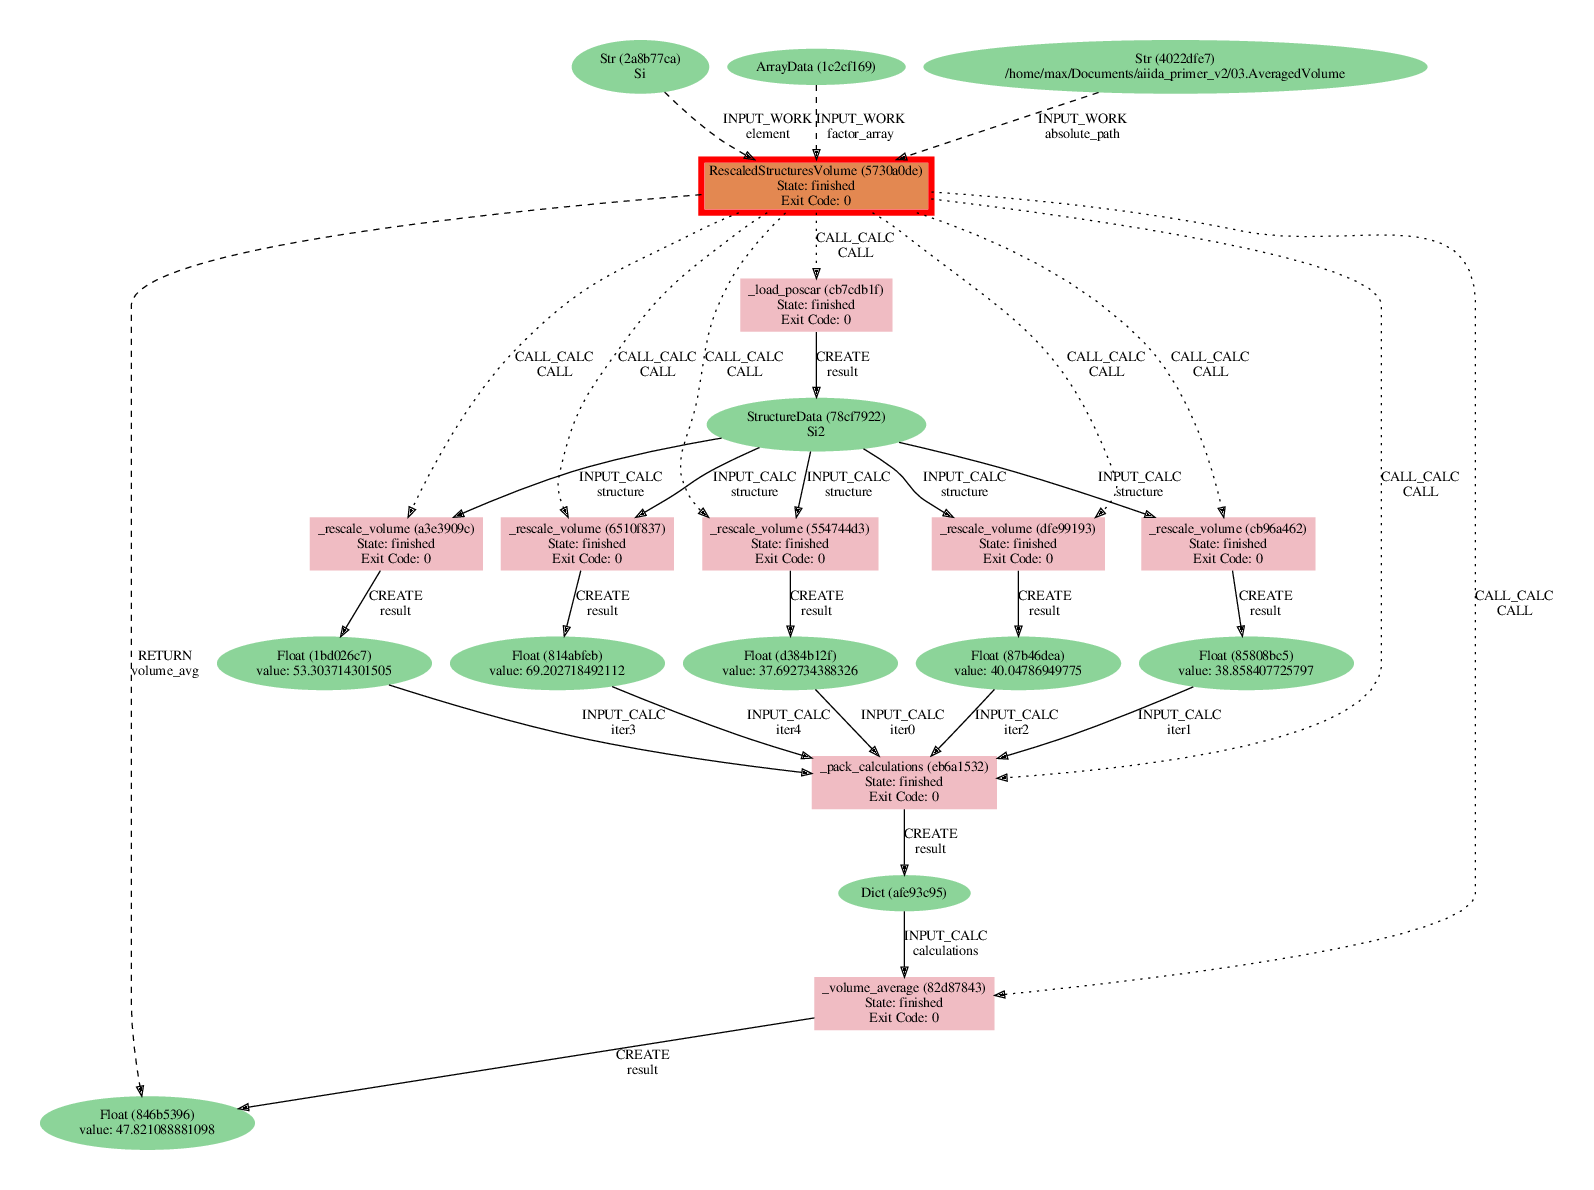

In [29]:
import subprocess
pk = node.pk
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))